In [1]:
from google.cloud import bigquery
import gmaps
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter

In [2]:
client = bigquery.Client(project='bachelor-data-analysis')
dataset_ref = client.dataset('bachelor_data')
dataset = client.get_dataset(dataset_ref)

In [3]:
# gmaps authorization for heatmap visualization
maps_api_key = ''
with open('/Users/ajhamilton/keys/maps-api-key.txt') as f:
    maps_api_key = f.readline().strip()
    
gmaps.configure(api_key=maps_api_key)

# Contestant Location Heatmap

In [4]:
table_ref = dataset.table('contestant_details')
table = client.get_table(table_ref)
fields = [table.schema[5]]  # just the hometown column
hometowns = client.list_rows(table, selected_fields=fields).to_dataframe()

In [5]:
table_ref = dataset.table('hometown_coordinates')
table = client.get_table(table_ref)
coordinates = client.list_rows(table).to_dataframe()

In [6]:
# map coordinates to contestant hometowns
hometown_coordinates = hometowns.merge(coordinates, how='left', left_on='hometown', right_on='city')
# transform to list of tuple(latitude, longitude) for gmaps
locations = [(row.lat, row.long) for _, row in hometown_coordinates.iterrows()]

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations))
# Note: the image below is a static png because the interactive tool does not render in Github
fig

Figure(layout=FigureLayout(height='420px'))

<img src="map.png" alt="Contestant Location Heatmap"/>

# Winners Who Received the First Impression Rose

In [7]:
# Calculate the number of seasons that have first impression rose(s)
query = """
SELECT COUNT(*) 
FROM (
    SELECT DISTINCT show, season
    FROM `bachelor-data-analysis.bachelor_data.event_log`
    WHERE action = 'R1'
)
"""
seasons_w_FIR = list(client.query(query))[0][0]
seasons_w_FIR

27

In [8]:
# Calculate the number of first impression rose recipients
# Note that a season may have zero to many first impression roses
query = """
SELECT COUNT(*) 
FROM `bachelor-data-analysis.bachelor_data.event_log`
WHERE action = 'R1'
"""
count_of_recipients = list(client.query(query))[0][0]
count_of_recipients

46

In [9]:
query = """
SELECT show, season, full_name 
FROM `bachelor-data-analysis.bachelor_data.event_log`
WHERE unique_id IN
(
    SELECT unique_id
    FROM `bachelor-data-analysis.bachelor_data.event_log`
    WHERE action = 'R1'
)
AND action = 'W'
"""
winners_w_FIR = client.query(query).to_dataframe()
percent_of_recipients = round(len(winners_w_FIR) / count_of_recipients * 100, 2)
percent_of_seasons = round(len(winners_w_FIR) / seasons_w_FIR * 100, 2)
print("{}% of First Impression Rose recipients were winners".format(percent_of_recipients))
print("This represents {}% of seasons with First Impression Roses".format(percent_of_seasons))
winners_w_FIR

13.04% of First Impression Rose recipients were winners
This represents 22.22% of seasons with First Impression Roses


,show,season,full_name
0,Bachelor,17,Catherine Giudici
1,Bachelorette,4,Jesse Csincsak
2,Bachelorette,11,Shawn Booth
3,Bachelorette,13,Bryan Abasolo
4,Bachelorette,6,Roberto Martinez
5,Bachelorette,12,Jordan Rodgers


# Common Names

_Hypothesis: There are more people named Lauren on the Bachelor than in real life_

In [10]:
# Prepare DataFrame of top 10 Bachelor contestant first names
query = """
SELECT show, REGEXP_EXTRACT(full_name, r"^[a-zA-Z.']+") AS first_name
FROM `bachelor-data-analysis.bachelor_data.contestant_details`
WHERE show = 'Bachelor'
"""
bach_names = client.query(query).to_dataframe()
bach_names = bach_names.groupby('first_name').size().reset_index(name='count')
bach_names['percentage'] = bach_names['count'] / bach_names['count'].sum() * 100
top_bach_names = bach_names.nlargest(10, 'percentage')[['first_name', 'percentage']]

In [11]:
# Prepare DataFrame of first names of women born between 1970 and 1995 
# (approximate contestant age range)
query = """
SELECT name as first_name, SUM(number) as count
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE year BETWEEN 1970 AND 1995 AND GENDER = 'F' AND name IN UNNEST(@top_names)
GROUP BY first_name
"""
top_names = list(top_bach_names.first_name)
query_param = bigquery.ArrayQueryParameter('top_names', 'STRING', top_names)
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = [query_param]
usa_names = client.query(query, job_config=job_config).to_dataframe()

In [12]:
# Calcualate each name's popularity
query = """
SELECT SUM(number) as total
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE year BETWEEN 1970 AND 1995 AND GENDER = 'F'
"""
total_count = list(client.query(query))[0].total
usa_names['percentage'] = usa_names['count'] / total_count * 100
usa_names.drop('count', axis=1, inplace=True)  # 'count' column is no longer needed

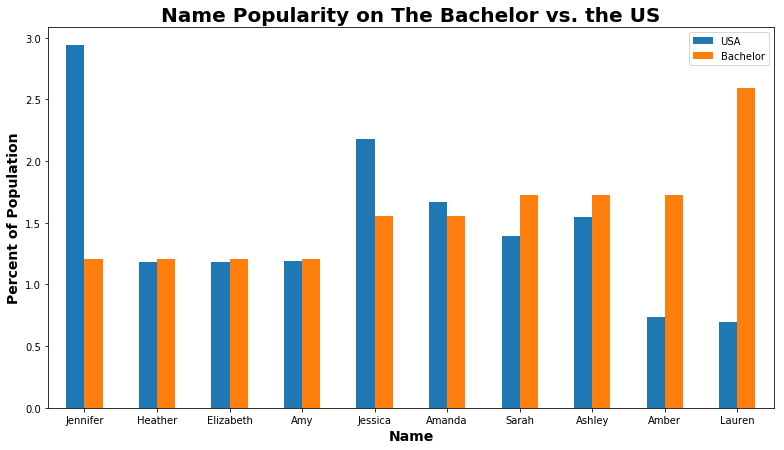

In [13]:
name_frequencies = usa_names.merge(top_bach_names, how='left', on='first_name', suffixes=['_usa','_bach'])
name_frequencies.sort_values('percentage_bach', inplace=True)

ax = name_frequencies.plot(kind='bar', x='first_name', figsize=(13,7), rot=0)
ax.legend(['USA', 'Bachelor'])
ax.set_title('Name Popularity on The Bachelor vs. the US', fontweight='bold', fontsize=20)
ax.set_ylabel('Percent of Population', fontweight='bold', fontsize=14)
ax.set_xlabel('Name', fontweight='bold', fontsize=14)
plt.show()

# Age of the Bachelor/Bachelorette Over Time

In [14]:
query = """
SELECT start_date, age, show
FROM `bachelor-data-analysis.bachelor_data.season_details`
ORDER BY start_date
"""
lead_age_df = client.query(query).to_dataframe()

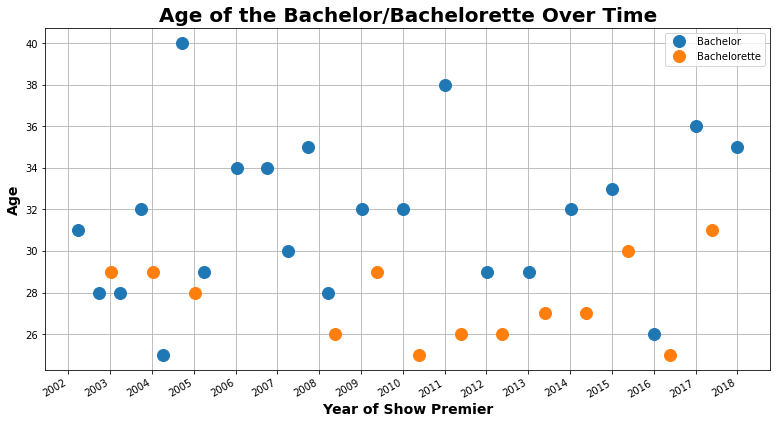

In [15]:
groups = lead_age_df.groupby('show')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot_date(group.start_date, group.age, 'o', linestyle='', ms=12, label=name)
ax.legend()
    
# format the ticks
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.autoscale_view()
ax.margins(0.05)
ax.grid(True)
fig.autofmt_xdate()  # makes years diagonal

ax.set_title('Age of the Bachelor/Bachelorette Over Time', fontweight='bold', fontsize=20)
ax.set_ylabel('Age', fontweight='bold', fontsize=14)
ax.set_xlabel('Year of Show Premier', fontweight='bold', fontsize=14)
fig.set_figheight(7)
fig.set_figwidth(13)
plt.show()

In [16]:
groups.describe()

age                                                   
             count       mean       std   min   25%   50%   75%   max
show                                                                 
Bachelor      22.0  31.636364  3.811580  25.0  29.0  32.0  34.0  40.0
Bachelorette  13.0  27.538462  1.941451  25.0  26.0  27.0  29.0  31.0